In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter
from functools import partial
import _pickle as cPickle

from tqdm import tqdm # to measure progress of for loops

/var/folders/sp/wlr6xm2979l8vx6kjh2z1dk00000gn/T/ipykernel_15151/3896996703.py:9: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na', True)


In [2]:
raw_data = pd.read_pickle(r'dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [3]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
        return 0

In [4]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

#### Long term performance with AdaBoostClassifier and Finding Optimal Hyperparameters

In [6]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [7]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]

In [8]:
training_frames[0]

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2001-01-04,FDO,762.484,356.469,1285.371,831.212,0.207,535.734,171.2910,172.062,183.752,...,0,0,0,0,0,0,0,0,0,1
2001-01-04,FUJIY,11625.204,1406.343,20778.250,14726.288,6193.500,3621.778,514.6260,514.626,514.626,...,0,0,0,0,0,0,0,0,0,1
2001-01-04,NRG,672.658,263.108,5978.992,1462.088,107.378,523.676,165.8610,182.030,180.001,...,0,0,0,0,0,0,0,0,0,1
2001-01-04,UBS,0.000,233964.000,585134.000,21388.937,43090.067,2701.902,395.0820,407.438,431.698,...,0,0,1,0,0,0,0,0,0,0
2001-01-05,THC,3529.000,696.000,13121.000,4584.000,187.000,2409.000,313.7930,325.726,320.250,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-12-23,MITSY,33462.887,14015.209,58080.035,8214.489,6844.386,50523.573,79.0965,79.114,79.184,...,0,0,0,0,0,0,0,0,0,0
2003-12-23,SVU,1962.064,1256.227,6117.381,2142.161,52.274,4024.789,133.8083,135.862,150.670,...,0,0,0,0,0,0,0,0,0,1
2003-12-24,CBK,122.502,4.599,200.842,175.700,72.022,62.210,37.7123,38.705,42.204,...,0,0,0,0,0,0,0,0,0,1


In [9]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [10]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [11]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [12]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [13]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])

In [14]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

#### Define two different objective functions (one for accuracy and one for max drawdown).

In [15]:
def objective_accuracy(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,3,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
 
    return accuracy

In [16]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [17]:
def objective_max_drawdown(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,3,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)

    predicted_rets = preds * val_rets
    profit = predicted_rets.sum()

    max_draw = max_drawdown(predicted_rets)
    
    return max_draw

#### Find the optimal hyperparameters using each objective

In [18]:
optimal_hyperparameters_accuracy = {}
study_1 = optuna.create_study(direction="maximize")

optimal_hyperparameters_drawdown = {}
study_2 = optuna.create_study(direction="minimize")

Find the optimal hyper parameters during the first training period 2001-01-01 to 2004-01-01

In [19]:
%%time
study_1.optimize(partial(objective_accuracy,
                           train=training_data[0],
                           labels=training_labels[0],
                           val=valid_data[0],
                           val_labels=valid_labels[0],
                           val_rets=valid_frames[0]['next_period_return']), n_trials=25,n_jobs=-1)
    
optimal_hyperparameters_accuracy = study_1.best_params
print(study_1.best_params)

{'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.4}
CPU times: user 14min 6s, sys: 8.38 s, total: 14min 14s
Wall time: 1min 49s


In [20]:
%%time
study_2.optimize(partial(objective_max_drawdown,
                           train=training_data[0],
                           labels=training_labels[0],
                           val=valid_data[0],
                           val_labels=valid_labels[0],
                           val_rets=valid_frames[0]['next_period_return']), n_trials=25,n_jobs=-1)
    
optimal_hyperparameters_drawdown = study_2.best_params  
print(study_2.best_params)

{'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.2}
CPU times: user 11min 57s, sys: 6.7 s, total: 12min 4s
Wall time: 1min 52s


#### Open and read the 3 sets of optimal features over the holding period 2003 - 2018

In [21]:
with open(r'Data for HW 3/shap_features_ada.pkl','rb') as f:
    shap_1 = cPickle.load(f)
with open(r'Data for HW 3/shap_features_ada_01.pkl','rb') as f:
    shap_2 = cPickle.load(f)
with open(r'Data for HW 3/shap_features_ada_02.pkl','rb') as f:
    shap_3 = cPickle.load(f)

### For each combination of optimal features and hyperparameters, instantiate the AdaBoostClassifier with the features and compute the max drawdown for each of them.

#### 1: Optimal Hyperparameters 1 (Accuracy Objective)

In [22]:
optimal_hyperparameters_accuracy

{'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.4}

In [23]:
ada_clf_objective = AdaBoostClassifier(DecisionTreeClassifier(max_depth=optimal_hyperparameters_accuracy['max_depth']),
                                       n_estimators=optimal_hyperparameters_accuracy['n_estimators'],
                                       learning_rate=optimal_hyperparameters_accuracy['learning_rate'])

In [24]:
classifiers_shap_1 = [ada_clf_objective for i in range(len(start_dates) - 1)]
classifiers_shap_2 = [ada_clf_objective for i in range(len(start_dates) - 1)]
classifiers_shap_3 = [ada_clf_objective for i in range(len(start_dates) - 1)]

In [25]:
def train_classifiers(classifiers, shap_feats):
    scalers = [StandardScaler() for i in range(len(start_dates)-1)]
    opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_feats[i]].values),columns=shap_feats[i]) for i in range(len(start_dates)-1)]
    opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_feats[i]].values),columns=shap_feats[i]) for i in range(len(start_dates)-1)]
    opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_feats[i]].values),columns=shap_feats[i]) for i in range(len(start_dates)-1)]

    x = [1]
    ret = []
    
    for i in tqdm(range(len(start_dates)-1)):
            classifiers[i].fit(opt_training_data[i],training_labels[i])
    
            preds = classifiers[i].predict(opt_test_data[i])
            profit_i = (preds*test_frames[i]['next_period_return']).sum()
            ret.append(profit_i)
            num_names = len(opt_test_data[i])
            x.append(x[i] + (x[i]/num_names)*profit_i)

    return x, ret

In [26]:
# Shap Features Set 1
x_1, ret_1 = train_classifiers(classifiers_shap_1, shap_1)

100%|███████████████████████████████████████████| 56/56 [19:12<00:00, 20.57s/it]


In [27]:
# Shap Features Set 2
x_2, ret_2 = train_classifiers(classifiers_shap_2, shap_2)

100%|███████████████████████████████████████████| 56/56 [17:59<00:00, 19.28s/it]


In [28]:
# Shap Features Set 3
x_3, ret_3 = train_classifiers(classifiers_shap_3, shap_3)

100%|███████████████████████████████████████████| 56/56 [03:26<00:00,  3.68s/it]


In [29]:
# Import and read the SPY dataset
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

In [30]:
SPY['strategy_1'] = x_1
SPY['strategy_2'] = x_2
SPY['strategy_3'] = x_3

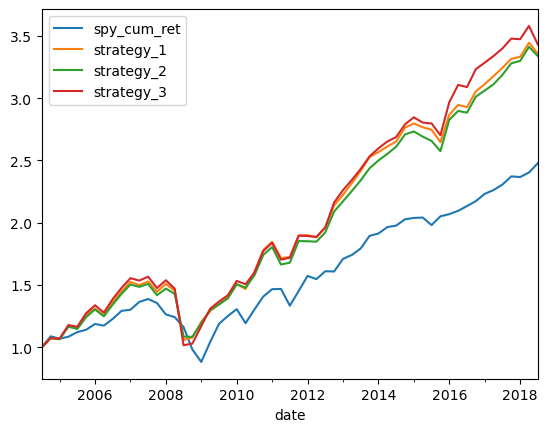

In [31]:
# SPY = SPY.iloc[1:].resample('A').bfill()
SPY.plot();

In [32]:
# Function to compute and plot the max drawdown for each strategy
def max_dd_strats(strat_labels):
    for strat in strat_labels:
        returns = SPY[strat].values[:-2]
        i = np.argmax(np.maximum.accumulate(returns) - returns)
        j = np.argmax(returns[:i])
        plt.plot(returns, label=strat);
        plt.plot([i, j], [returns[i], returns[j]], 'o', color='Red', markersize=10)
        print(f'The max drawdown for {strat} is {np.abs(returns[j] - returns[i])}')
    plt.legend()

The max drawdown for strategy_1 is 0.37011133168960764
The max drawdown for strategy_2 is 0.34521343912984115
The max drawdown for strategy_3 is 0.4469098856398048


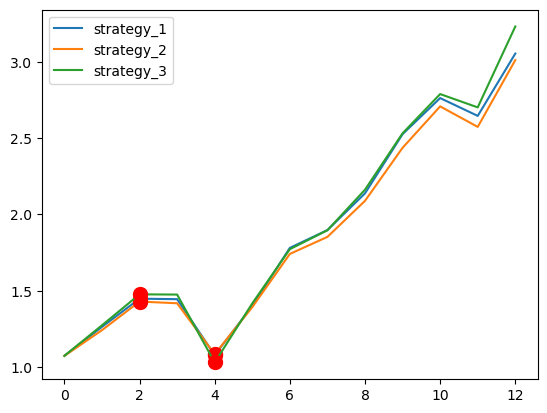

In [33]:
SPY = SPY.iloc[1:].resample('A').bfill()
max_dd_strats(['strategy_1', 'strategy_2', 'strategy_3'])

In [34]:
def sharpe_ratio_strats(strat_labels):
    for strat in strat_labels:
        strategy_mean_ret = (SPY[strat] - 1).diff().mean()
        strategy_std = (SPY[strat] - 1).diff().std()
        strategy_sr = strategy_mean_ret/strategy_std
        print(f'The Sharpe Ratio for {strat} is: {strategy_sr}')

In [35]:
SPY = SPY.resample('Y').ffill()
sharpe_ratio_strats(['strategy_1', 'strategy_2', 'strategy_3'])

The Sharpe Ratio for strategy_1 is: 0.7755875462339834
The Sharpe Ratio for strategy_2 is: 0.7844852507777246
The Sharpe Ratio for strategy_3 is: 0.7400953034232775


#### 2: Optimal Hyperparameters 2 (Max Drawdown Objective)

In [36]:
optimal_hyperparameters_drawdown

{'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.2}

In [37]:
ada_clf_objective = AdaBoostClassifier(DecisionTreeClassifier(max_depth=optimal_hyperparameters_drawdown['max_depth']),
                                       n_estimators=optimal_hyperparameters_drawdown['n_estimators'],
                                       learning_rate=optimal_hyperparameters_drawdown['learning_rate'])

In [38]:
classifiers_shap_1 = [ada_clf_objective for i in range(len(start_dates) - 1)]
classifiers_shap_2 = [ada_clf_objective for i in range(len(start_dates) - 1)]
classifiers_shap_3 = [ada_clf_objective for i in range(len(start_dates) - 1)]

In [39]:
# Shap Features Set 1
x_4, ret_4 = train_classifiers(classifiers_shap_1, shap_1)

100%|███████████████████████████████████████████| 56/56 [19:09<00:00, 20.52s/it]


In [40]:
# Shap Features Set 2
x_5, ret_5 = train_classifiers(classifiers_shap_2, shap_2)

100%|███████████████████████████████████████████| 56/56 [14:36<00:00, 15.65s/it]


In [41]:
# Shap Features Set 3
x_6, ret_6 = train_classifiers(classifiers_shap_3, shap_3)

100%|███████████████████████████████████████████| 56/56 [02:36<00:00,  2.79s/it]


In [42]:
# Import and read the SPY dataset
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

In [43]:
SPY['strategy_4'] = x_4
SPY['strategy_5'] = x_5
SPY['strategy_6'] = x_6

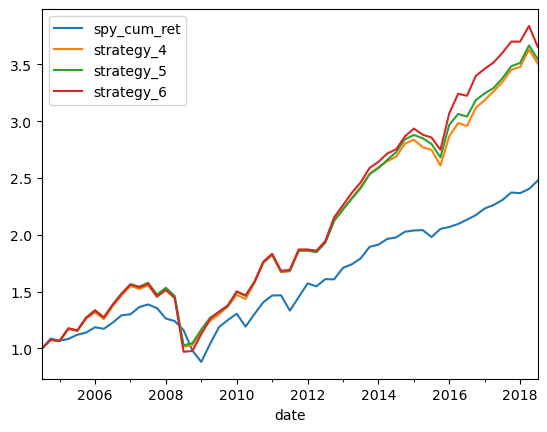

In [44]:
SPY.plot();

The max drawdown for strategy_4 is 0.438210267409908
The max drawdown for strategy_5 is 0.4370627807089724
The max drawdown for strategy_6 is 0.5030831108135541


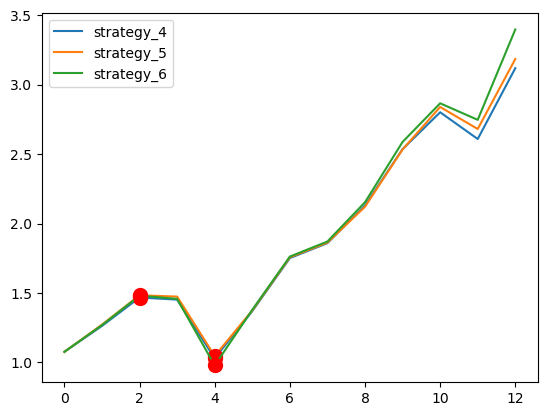

In [45]:
SPY = SPY.iloc[1:].resample('A').bfill()
max_dd_strats(['strategy_4', 'strategy_5', 'strategy_6'])

In [46]:
SPY = SPY.resample('Y').ffill()
sharpe_ratio_strats(['strategy_4', 'strategy_5', 'strategy_6'])

The Sharpe Ratio for strategy_4 is: 0.7026551977035782
The Sharpe Ratio for strategy_5 is: 0.7242743678519502
The Sharpe Ratio for strategy_6 is: 0.706931084267567


## Now we choose the optimal features and optuna objective from the above that gives us a good Sharpe ratio and small max drawdown.

From the performances above we can conclude that strategy 3 (i.e. Shap feature set 3 and hyper parameters optained using the accuracy for the Optuna objective) gives the desired values.

As in previous homeworks, we can change the labels to see if we can improve our strategy:

We insert a column in the dataset where entries are:  
- 2 if the stock return is more than 5% higher than the SPY return  
- 1 if it is between 1% and 5% higher than the SPY return  
- 0 if it is between -2.5% and +1% relative to the SPY return  
- -1 if it is below -2.5% relative to the SPY return

In [47]:
# function to return appropriate values based on performance as detailed above
def f_2(x):
    if x > 0.05:
        return 2
    elif x > 0.01:
        return 1
    elif x > -0.025:
        return 0
    else:
        return -1

#### Import data, make labels, split into training, validation, and test frames.

In [48]:
raw_data = pd.read_pickle(r'dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [49]:
data['rel_performance'] = data['pred_rel_return'].apply(f_2)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [50]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [51]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]

In [52]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [53]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [54]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [55]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [56]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])

#### Train the classifiers using the selected shap feature set and optimal hyperparameters.

In [57]:
optimal_hyperparameters_accuracy

{'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.4}

In [58]:
shap_2[-1]

Index(['prccq', 'gpmq', 'txpdy', 'bmq', 'oepsxy', 'evmq', 'debt_ebitdaq',
       'invt_actq', 'efftaxq', 'at_turnq',
       ...
       'sic_3678', 'ibcy', 'oepf12', 'fqtr_3', 'cshiq', 'dvpspq', 'rect_turnq',
       'int_totdebtq', 'cogsq', 'dvy'],
      dtype='object', length=133)

In [59]:
ada_clf_objective = AdaBoostClassifier(DecisionTreeClassifier(max_depth=optimal_hyperparameters_accuracy['max_depth']),
                                       n_estimators=optimal_hyperparameters_accuracy['n_estimators'],
                                       learning_rate=optimal_hyperparameters_accuracy['learning_rate'])

In [60]:
classifiers_ada = [ada_clf_objective for i in range(len(start_dates) - 1)]

In [61]:
x, ret = train_classifiers(classifiers_ada, shap_2)

100%|███████████████████████████████████████████| 56/56 [13:55<00:00, 14.91s/it]


#### Evaluate its performance over the holding period 2004 - 2018

In [62]:
# Import and read the SPY dataset
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

/var/folders/sp/wlr6xm2979l8vx6kjh2z1dk00000gn/T/ipykernel_15515/1499170714.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)


In [63]:
SPY['strategy'] = x

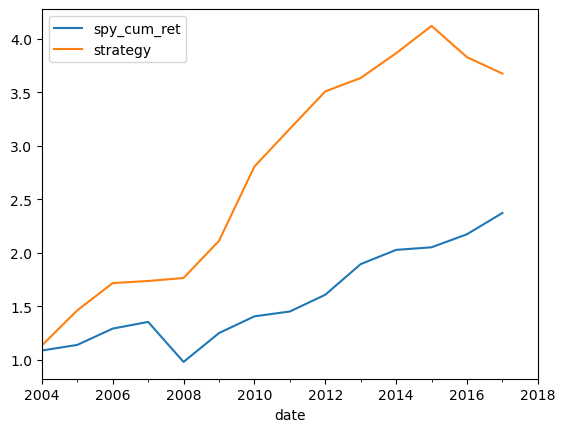

In [64]:
SPY = SPY.iloc[1:].resample('A').bfill()
SPY.plot();

The max drawdown for strategy is 0.2915385241818056


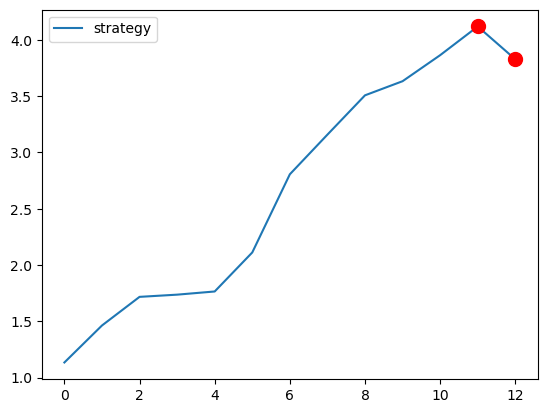

In [65]:
max_dd_strats(['strategy'])

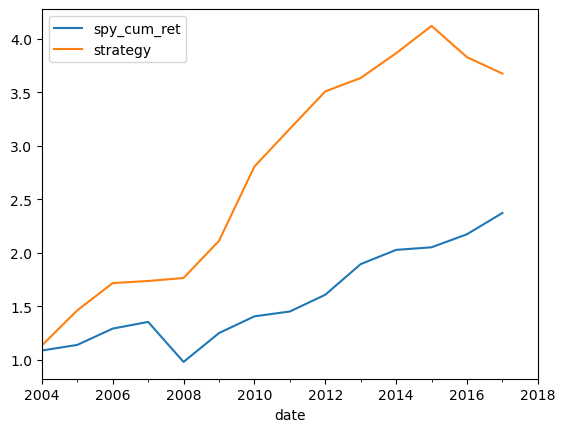

In [66]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [67]:
sharpe_ratio_strats(['strategy'])

The Sharpe Ratio for strategy is: 0.7716614875830043


### Conclusion
In conclusion, we had 3 sets of possible features (computed using Shapley values), 
and 2 different measures for the objective function to find optimal hyperparameters (accuracy and drawdown).

After training and evaluating the models on the 6 possible combinations, we chose the ones that gave us the desired properties.
Then we adjusted the labels as in previous homeworks to improve our strategy and finally:

We have found a strategy using an AdaBoostClassifier that has both:
- a good Sharpe ratio that is close to 1 (~0.772), which is a good measure of returns after adjusting for risk
- and a small max drawdown (~0.292) which can help ease investors